In [1]:
import pandas as pd
import numpy as np
import os
import math

In [5]:
def dist(location_test):
    dist=[]
    loc_list=location_test.values
    for i in range(len(location_test)):
        tmp=[]
        for j in range(len(location_test)):
            tmp.append(np.linalg.norm(loc_list[i]-loc_list[j]))
        dist.append(tmp)
    return dist

In [8]:
# dists[0][0]
# dists=dist(locatin)
# dist=np.array(dists)
# np.save('C:/Users/wk/Desktop/黄涛/毕设/CAE_Cluster/5wan/dists',dist)

In [240]:
def savelabel(loc,label):
    n=len(set(label))
    dic0={}
    for i in label:
        if i in dic0:
            dic0[i]+=1
        else:
            dic0[i]=1
    sorted_x = sorted(dic0.items(), key=lambda x : x[1], reverse=True)
    newlabel=[-1]*len(label)
    for i in range(n):
        k,v=sorted_x[i]
        for j in range(len(label)):
            if label[j]==k:
                newlabel[j]=i           
    data=[]
    dic={}
    for i in range(loc.shape[0]):
        loc1=loc[i]
        lab=newlabel[i]
        for j in range(loc1.shape[0]):
            x,y=loc1[j]
            if (y,x) in dic:
                dic[(y,x)].append(lab)
            else:
                dic[(y,x)]=[lab]
    for tup in dic:
        y,x=tup
        count=0
        dic1={}
        lis=dic[tup]
        for lab in lis:
            if lab in dic1:
                dic1[lab]+=1
            else:
                dic1[lab]=1
        mx=max(dic1.values())
        for k,v in dic1.items():
            if v==mx:
                mostlab=k
                break
        data.append([y,x,mostlab])
    
    return data

In [88]:
dist1=np.load('./out/CAE_Cluster/5wan/dists.npy')
dists=[]
for i in dist1:
    dists.append(list(i))

In [487]:
file_path='./data/5万水系.xlsx'
data=pd.read_excel(file_path,sheet_name='Sheet1')
print(data.head())

         Y        X    As    Sb    Bi    Co    Cu    Mo    Ni    Pb     W  \
0  10465.8  76750.4  25.2  4.09  0.31  12.9  23.1  0.55  26.9  18.9  2.31   
1  10463.4  76746.2  9.42   0.9  0.32  13.8  28.2  1.18  26.9  45.5  3.96   
2  10475.2  76741.6  19.2  5.35  0.32  12.8  26.8  0.75  26.5  29.0  7.34   
3  10494.2  76753.8  26.8  4.84  0.32  14.7  26.4  0.53  29.9  21.0  2.41   
4  10490.8  76744.8  9.27  0.88  0.34  14.6  27.8  0.66  31.4  32.8  5.90   

     Zn    Au    Ag  
0  63.3  1.66  0.10  
1  65.2  1.22  0.09  
2  68.6  0.42  0.07  
3  78.1  0.88  0.07  
4  75.0  0.30  0.09  


In [488]:
location_test=data.loc[:,['X','Y']]
data_test1=data.loc[:,['W','Mo']]# 选择对应元素
# 若无预先读入dists文件，需要在此进行dists数组的计算 
# dists = dist(location_test)

print(data_test1[0:1])
print(location_test.shape)
print(dist1[0][0])

      W    Mo
0  2.31  0.55
(11482, 2)
0.0


In [489]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler() #min-max标准化
#scaler = preprocessing.StandardScaler()  #z-score标准化
# data_trian = scaler.fit_transform(data_trian)
# data_test = scaler.fit_transform(data_test)
# data_trian1=scaler.fit_transform(data_trian1) 
data_test1=scaler.fit_transform(data_test1) 
# data_trian2=scaler.fit_transform(data_trian2) 
# data_test2=scaler.fit_transform(data_test2) 

In [490]:
#滑动窗口长度；步长
sequence_length = 32#采样点数量
time_step =8#滑窗步长

In [491]:
def get_data1(start, end, data,location, sequence_length, time_step,dist):
    import heapq
    result=[]
    newloc=[]
    loc1=location.values
    for i in range(start,end,time_step):
        tmp=dist[i]
        idx=map(tmp.index,heapq.nsmallest(sequence_length,tmp))
        idx=sorted(idx)
        res=[]
        newl=[]
        for j in idx:
            res.append(data[j])
            newl.append(loc1[j])
        result.append(res)
        newloc.append(newl)
    result=np.array(result)
    newloc=np.array(newloc)
    return result,newloc
            

In [492]:
X_test,loc_test = get_data1(0, len(data_test1), data_test1,location_test, sequence_length, time_step,dists)
print(X_test.shape)
print(data_test1.shape)

(1436, 32, 2)
(11482, 2)


In [493]:
# import tensorflow as tf 
from keras.models import Model,Input,load_model, Sequential 
from keras.layers import Conv1D, Dropout, Dense  
from keras.layers import MaxPooling1D, UpSampling1D, Flatten, Reshape 
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

In [494]:
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, RepeatVector
from keras.layers.noise import GaussianDropout,GaussianNoise

In [495]:
sample_length=X_test.shape[1]
feature_dim=X_test.shape[2]
print(sample_length,feature_dim)

32 2


In [496]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [497]:
data=Input(shape=(sample_length,feature_dim ))
x=GaussianNoise(0.01)(data)
x=Conv1D(filters=16, kernel_size=5, padding='same', activation='relu',input_shape=(sample_length, feature_dim))(data)
x=MaxPooling1D(pool_size=2)(x)
x=Conv1D(filters=8, kernel_size=3, padding='same', activation='relu',input_shape=(sample_length//2,16))(x)
x=MaxPooling1D(pool_size=2)(x)
x=Conv1D(filters=8, kernel_size=3, padding='same', activation='relu',input_shape=(sample_length//4,8))(x)
encoded=MaxPooling1D(pool_size=2)(x)

x=UpSampling1D(size=2)(encoded)
x=Conv1D(filters=8, kernel_size=3, padding='same', activation='relu',input_shape=(sample_length//4,8))(x)
x=UpSampling1D(size=2)(x)
x=Conv1D(filters=8, kernel_size=3, padding='same', activation='relu',input_shape=(sample_length//2,8))(x)
x=UpSampling1D(size=2)(x)
x=Conv1D(filters=16, kernel_size=5, padding='same', activation='relu',input_shape=(sample_length,8))(x)
decoded=Conv1D(filters= feature_dim, kernel_size=5, padding='same', activation='sigmoid',input_shape=(sample_length,16))(x)
       
autoencoder = Model(data, decoded)
autoencoder.compile(loss="mse", optimizer='adam')
encoder_model = Model(data,encoded)

In [498]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
autoencoder.fit(X_test, X_test,epochs=100,batch_size=128,shuffle=True,validation_split=0.1,callbacks=[early_stopping])

Train on 1292 samples, validate on 144 samples
Epoch 1/100
1292/1292 [==============================] - 3s 2ms/step - loss: 0.2406 - val_loss: 0.2380
Epoch 2/100
1292/1292 [==============================] - 0s 106us/step - loss: 0.2342 - val_loss: 0.2289
Epoch 3/100
1292/1292 [==============================] - 0s 101us/step - loss: 0.2204 - val_loss: 0.2050
Epoch 4/100
1292/1292 [==============================] - 0s 105us/step - loss: 0.1828 - val_loss: 0.1412
Epoch 5/100
1292/1292 [==============================] - 0s 101us/step - loss: 0.0969 - val_loss: 0.0375
Epoch 6/100
1292/1292 [==============================] - 0s 99us/step - loss: 0.0167 - val_loss: 0.0035
Epoch 7/100
1292/1292 [==============================] - 0s 104us/step - loss: 0.0021 - val_loss: 8.1806e-04
Epoch 8/100
1292/1292 [==============================] - 0s 101us/step - loss: 7.6754e-04 - val_loss: 3.9759e-04
Epoch 9/100
1292/1292 [==============================] - 0s 96us/step - loss: 5.2500e-04 - val_loss: 2.8

1292/1292 [==============================] - 0s 100us/step - loss: 2.9622e-04 - val_loss: 1.0145e-04
Epoch 74/100
1292/1292 [==============================] - 0s 101us/step - loss: 2.9621e-04 - val_loss: 1.0143e-04
Epoch 75/100
1292/1292 [==============================] - 0s 100us/step - loss: 2.9619e-04 - val_loss: 1.0141e-04
Epoch 76/100
1292/1292 [==============================] - 0s 101us/step - loss: 2.9618e-04 - val_loss: 1.0140e-04
Epoch 77/100
1292/1292 [==============================] - 0s 101us/step - loss: 2.9616e-04 - val_loss: 1.0139e-04
Epoch 78/100
1292/1292 [==============================] - 0s 100us/step - loss: 2.9615e-04 - val_loss: 1.0138e-04
Epoch 79/100
1292/1292 [==============================] - 0s 101us/step - loss: 2.9613e-04 - val_loss: 1.0137e-04
Epoch 80/100
1292/1292 [==============================] - 0s 98us/step - loss: 2.9611e-04 - val_loss: 1.0136e-04
Epoch 81/100
1292/1292 [==============================] - 0s 103us/step - loss: 2.9609e-04 - val_loss:

In [499]:
encoded_data =encoder_model.predict(X_test)
print(X_test.shape)
print(encoded_data.shape)
# print(encoded_data[0])

(1436, 32, 2)
(1436, 4, 8)


In [500]:
encoded_data1=np.sum(encoded_data,axis=2)
# encoded_data1=encoded_data.reshape([498,32])
print(encoded_data1[0])
print(encoded_data1.shape)

[3.0512414 3.0570042 3.0141706 3.0114627]
(1436, 4)


In [501]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import calinski_harabaz_score

In [502]:
# X=encoded_data1
# scores=[]
# s=dict()
# label={}
# for index,gamma in enumerate([0.01,0.1,1,10]):
#     for index,k in enumerate(range(4,14)):
#         pred_y=SpectralClustering(n_clusters=k, gamma=gamma).fit_predict(X)
#         print("Calinski-Harabasz Score with gamma=",gamma,"n_cluster=",k,"score=",calinski_harabaz_score(X,pred_y))
#         tmp=dict()
#         tmp['gamma']=gamma
#         tmp['n_cluster']=k
#         tmp['score']=calinski_harabaz_score(X,pred_y)
#         s[calinski_harabaz_score(X,pred_y)]=tmp
#         label[(gamma,k)]=pred_y
#         scores.append(calinski_harabaz_score(X,pred_y))
# gamma,n_cluster=s.get(np.max(scores))['gamma'],s.get(np.max(scores))['n_cluster']
# last_label=label[(gamma,n_cluster)]
# print(np.max(scores))
# print("最大得分项：")
# print(s.get(np.max(scores)))

In [503]:
#KNN法构造邻接矩阵
X=encoded_data1
scores=[]
s=dict()
label={}
for index,nb in enumerate([8,9,10,11,12,13,14,15,16]):
    for index,k in enumerate(range(9,15)):
        pred_y=SpectralClustering(affinity='nearest_neighbors',n_clusters=k, n_neighbors=nb).fit_predict(X)
        print("Calinski-Harabasz Score with n_neighbors=",nb,"n_cluster=",k,"score=",calinski_harabaz_score(X,pred_y))
        tmp=dict()
        tmp['n_neighbors']=nb
        tmp['n_cluster']=k
        tmp['score']=calinski_harabaz_score(X,pred_y)
        s[calinski_harabaz_score(X,pred_y)]=tmp
        label[(nb,k)]=pred_y
        scores.append(calinski_harabaz_score(X,pred_y))
nb,n_cluster=s.get(np.max(scores))['n_neighbors'],s.get(np.max(scores))['n_cluster']
last_label=label[(nb,n_cluster)]
print(np.max(scores))
print("最大得分项：")
print(s.get(np.max(scores)))

Calinski-Harabasz Score with n_neighbors= 8 n_cluster= 9 score= 142.84103639961594
Calinski-Harabasz Score with n_neighbors= 8 n_cluster= 10 score= 126.3528273633761
Calinski-Harabasz Score with n_neighbors= 8 n_cluster= 11 score= 114.6898890597528
Calinski-Harabasz Score with n_neighbors= 8 n_cluster= 12 score= 105.40729043699463
Calinski-Harabasz Score with n_neighbors= 8 n_cluster= 13 score= 96.70264912313242
Calinski-Harabasz Score with n_neighbors= 8 n_cluster= 14 score= 89.46167511284202
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 9 score= 141.500040883181
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 10 score= 126.69726122573168
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 11 score= 114.53407726185624
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 12 score= 105.58442009633272
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 13 score= 96.88684073004958
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 14 score= 113.11554595396272
C

In [504]:
data=savelabel(loc_test,last_label)
data=pd.DataFrame(data)
data.columns=['Y','X','label']
with pd.ExcelWriter('./out/CAE_Cluster/5wan/WMo_9.xlsx') as writer:
    data.to_excel(writer,sheet_name='WMo')
print(data.shape)

(11428, 3)


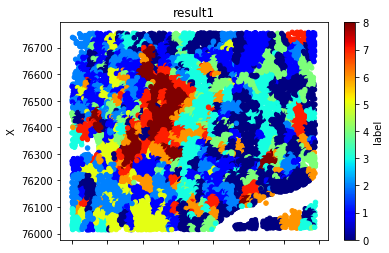

In [505]:
import matplotlib.pyplot as plt
data.plot.scatter('Y', 'X', c='label', colormap='jet')
plt.title('result1')
plt.show()